In [31]:
# !pip install catboost
# !pip install shap

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from sklearn import preprocessing
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

import shap

In [33]:
df_target = pd.read_csv('data/vkusvill_target.csv')
new_features = pd.read_csv('data/vkusvill_new_features_v2.csv')
data = pd.read_csv('data/vkusvill_data_without_target.csv')
revenue = df_target['Выручка р/мес'].values

In [34]:
work_schedule = [
    ['с 9-00 до 22-00', 9, 22, 9, 22, 0], 
    ['с 8-00 до 22-00', 8, 22, 8, 22, 0],
    ['пн-чт с 7-00 - 23-45, пт-сб с 8-00 - 23-00, вс с 7-00 - 23-45', 7, 23, 7, 23, 1],
    ['Откл. с 9:00 до 22:00', 9, 22, 9, 22, 0], 
    ['с 7-00 до 22-00', 7, 22, 7, 22, 0],
    ['будни с 8-00 до 22-00; вых. с 9-00 до 22-00', 8, 22, 9, 22, 1], 
    ['с 10-00 до 22-00', 10, 22, 10, 22, 0],
    ['будни с 9-00 до 23-00, выходные с 9-00 до 22-00', 9, 23, 9, 22, 1],
    ['с 9-00 до 21-00', 9, 21, 9, 21, 0], 
    ['Будни с 8 до 23, вых с 8 до 22', 8, 23, 8, 22, 1],
    ['с 7:00 до 23:45', 7, 23, 7, 23, 0], 
    ['Откл. с 11:00 до 21:00', 11, 21, 11, 21, 0],
    ['Откл. с 8:00 до 22:00', 8, 22, 8, 22, 0], 
    ['с 8-00 до 23-45', 8, 23, 8, 23, 0], 
    ['с 8-00 до 23-00', 8, 23, 8, 23, 0],
    ['Будни с8:00 до 23:00 вых с 8:00 до 22:00', 8, 23, 8, 22, 1],
    ['будни с 8-00 до 23-00, вых. 9-00 до 23-00', 8, 23, 9, 23, 1],
    ['пн-пт с 8-00 до 23-00, сб-вс с 9-00 до 22-00', 8, 23, 9, 22, 1],
    ['вс-чт. с 10:00 до 23:00, пт-сб. с 10:00 по 24:00', 10, 23, 10, 24, 1],
    ['пн-чт с 7-00 - 23-45, пт-сб с 7-00 - 23-00, вс с 7-00 - 23-45', 7, 23, 7, 23, 1],
    ['с 8-30 до 23-00', 8, 23, 8, 23, 0], 
    ['с 7-00 до 23-45', 7, 23, 7, 23, 0],
    ['пн-чт с 7-00 - 23-45, пт-сб с 7-00 - 22-00, вс с 8-00 - 23-45', 7, 23, 8, 23, 1],
    ['с пн по чт с 7 до 23:45, пт с 7 до 23:00, сб с 8 до 22:00, вс 8 до 23:45', 7, 23, 8, 23, 1],
    ['бд 7-00 до23-00 вх 8-00 до 22-00', 7, 23, 8, 22, 1], 
    ['с 9:00 до 23:00', 9, 23, 9, 23, 0],
    ['с 7-00 до 23-00', 7, 23, 7, 23, 0]
]

work_schedule = pd.DataFrame(
    work_schedule, 
    columns=["График", "Будни начало", "Будни конец", "Выходные начало", "Выходные конец", "Разные графики"]
    )

data = pd.merge(data, work_schedule, on="График", how="left")
data['Рабочие часы в будни'] = data['Будни конец'] - data['Будни начало']
data['Рабочие часы в выходные'] = data['Выходные конец'] - data['Выходные начало']
data['Ночной магазин'].replace({'Нет': 0, 'Да': 1}, inplace=True)

In [35]:
data = pd.concat([data, pd.get_dummies(data['Город'])], axis=1)

In [36]:
new_features_aggregated = pd.DataFrame(columns=['medicine', 'food', 'education', 'stations', 'housing',
                                                'for_motorists', 'shops', 'atms+banks', 'entertainment',
                                                'house', 'kindergarten', 'office'])

new_features_aggregated['medicine'] = new_features['clinic']+new_features['dentist']+\
                                      new_features['doctors']+new_features['hospital']+\
                                      new_features['pharmacy']

new_features_aggregated['food'] = new_features['food_court']+new_features['pub']+\
                                  new_features['restaurant']+new_features['cafe']+\
                                  new_features['bar']+new_features['fast_food']

new_features_aggregated['education'] = new_features['college']+new_features['driving_school']+\
                                       new_features['language_school']+new_features['school']+\
                                       new_features['university']
                                   
new_features_aggregated['stations'] = new_features['bus_stop']+new_features['station']+\
                                      new_features['subway_entrance']+new_features['tram_stop']     

new_features_aggregated['housing'] = new_features['hotel']+new_features['hostel']

new_features_aggregated['for_motorists'] = new_features['car_wash']+new_features['fuel']

new_features_aggregated['shops'] = new_features['kiosk']+new_features['retail']+new_features['shop']

new_features_aggregated['atms+banks'] = new_features['atm']+new_features['bank']

new_features_aggregated['entertainment'] = new_features['theatre']+new_features['cinema']

new_features_aggregated['house'] = new_features['house']
new_features_aggregated['kindergarten'] = new_features['kindergarten']
new_features_aggregated['office'] = new_features['office']
new_features_aggregated['dist_to_city_center'] = new_features['dist_to_city_center']

In [37]:
data = pd.concat([data, new_features_aggregated], axis=1)

In [38]:
data = data.drop(columns = ['Наименование', 'Номерточки', 'Регион', 'Город', 'Адрес', 'Широта', 'Долгота', 'График'], axis = 1)

In [39]:
scaler = preprocessing.MinMaxScaler()
d = scaler.fit_transform(data)

scaled_data = pd.DataFrame(d, columns=data.columns)

In [40]:
def model_training(model, data, target, result_to):
  X_train, y_train = data, target
  model = model
  cv = RepeatedKFold(n_splits=100, n_repeats=10, random_state=1)
  scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_percentage_error', cv=cv, n_jobs=-1)
  scores = np.absolute(scores)
  print(f'{model} revenue mean MAPE: %.3f' % scores.mean())
  result_to.append((f'{model}', scores.mean()))

  # X_train, y_train = data, all_data_test_avg_check.to_numpy()
  # forest = RandomForestRegressor()
  # cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
  # scores = cross_val_score(forest, X_train, y_train, scoring='neg_mean_absolute_percentage_error', cv=cv, n_jobs=-1)
  # scores = np.absolute(scores)
  # print(f'{model} avg_check mean MAPE: %.3f' % scores.mean())
  # results_avg_check.append((f'{model}', scores.mean()))

In [ ]:
results_revenue_with_new_features = []

In [291]:
model_training(RandomForestRegressor(),
               scaled_data, 
               revenue,
               results_revenue_with_new_features)
model_training(AdaBoostRegressor(n_estimators=100,random_state=1),
               scaled_data, 
               revenue,
               results_revenue_with_new_features)
model_training(GradientBoostingRegressor(n_estimators=100,random_state=1),
               scaled_data, 
               revenue,
               results_revenue_with_new_features)
model_training(XGBRegressor(n_estimators=100,random_state=1),
               scaled_data, 
               revenue,
               results_revenue_with_new_features)
model_training(CatBoostRegressor(),
               scaled_data, 
               revenue,
               results_revenue_with_new_features)

RandomForestRegressor() revenue mean MAPE: 0.186
AdaBoostRegressor(n_estimators=100, random_state=1) revenue mean MAPE: 0.210
GradientBoostingRegressor(random_state=1) revenue mean MAPE: 0.194
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=1, ...) revenue mean MAPE: 0.201
<catboost.core.CatBoostRegressor object at 0

In [292]:
results_revenue_with_new_features = sorted(results_revenue_with_new_features,key = lambda x: x[1])
# results_avg_check_with_new_features = sorted(results_avg_check_with_new_features,key = lambda x: x[1])

df_results_revenue_with_new_features = pd.DataFrame(results_revenue_with_new_features, columns=['model', 'result'])
# df_results_avg_check_with_new_features = pd.DataFrame(results_avg_check_with_new_features, columns=['model', 'result'])

In [293]:
df_results_revenue_with_new_features

,model,result
0,<catboost.core.CatBoostRegressor object at 0x7...,0.186300
1,RandomForestRegressor(),0.186310
2,GradientBoostingRegressor(random_state=1),0.193572
3,"XGBRegressor(base_score=None, booster=None, ca...",0.201039
4,"AdaBoostRegressor(n_estimators=100, random_sta...",0.210316


In [41]:
X_train, y_train = scaled_data[:260], revenue[:260]
X_test, y_test = scaled_data[260:], revenue[260:]

In [17]:
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [2,4,6]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [18]:
model = RandomForestRegressor()

In [20]:
rf_Grid = GridSearchCV(estimator = model, param_grid = param_grid, scoring='neg_mean_absolute_percentage_error',
                       cv = 100, verbose=2, n_jobs = -1)
rf_Grid.fit(X_train, y_train)

Fitting 100 folds for each of 1080 candidates, totalling 108000 fits


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


GridSearchCV(cv=100, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [2, 4, 6],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                          100]},
             scoring='neg_mean_absolute_percentage_error', verbose=2)

In [21]:
rf_Grid.best_params_

{'bootstrap': True,
 'max_depth': 6,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 50}

In [23]:
rf_RandomGrid = RandomizedSearchCV(estimator = model, param_distributions = param_grid,
                                   scoring='neg_mean_absolute_percentage_error',
                                   cv = 100, verbose=2, n_jobs = -1)
rf_RandomGrid.fit(X_train, y_train)

Fitting 100 folds for each of 10 candidates, totalling 1000 fits


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


RandomizedSearchCV(cv=100, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [2, 4, 6],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100]},
                   scoring='neg_mean_absolute_percentage_error', verbose=2)

In [24]:
rf_RandomGrid.best_params_

{'n_estimators': 20,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 6,
 'bootstrap': True}

In [25]:
rf_Grid.score(X_train,y_train)

-0.12731846906192137

In [26]:
rf_Grid.score(X_test,y_test)

-0.19214395135575493

In [27]:
rf_RandomGrid.score(X_train,y_train)

-0.13231527874514884

In [28]:
rf_RandomGrid.score(X_test,y_test)

-0.19577909716256747

In [42]:
model = RandomForestRegressor( n_estimators = 50,
                               min_samples_split = 10,
                               min_samples_leaf = 4,
                               max_features = 'auto',
                               max_depth = 6,
                               bootstrap = True)
model.fit(X_train, y_train)
y_pred_test = model.predict(X_test)
print('RandomForestRegressor revenue MAPE: %.3f' % metrics.mean_absolute_percentage_error(y_test, y_pred_test))

explainer = shap.Explainer(model.predict, X_test)
shap_values = explainer(X_test)

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


RandomForestRegressor revenue MAPE: 0.191


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


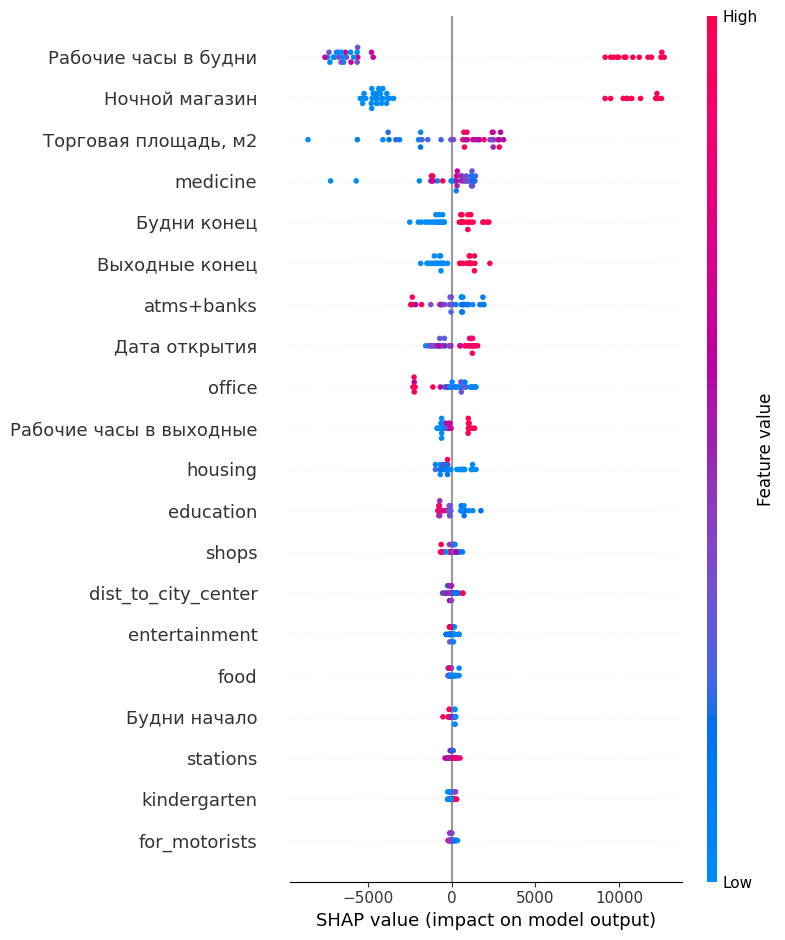

In [43]:
shap.summary_plot(shap_values)